In [8]:
import os, pickle
from tqdm import tqdm  # Import tqdm for progress tracking
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import pyemma
import pyemma.coordinates as coor
from joblib import Parallel, delayed


## Load in important functions

In [9]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)
    

In [7]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

## Prepare the Data and the log (indicating of the data state)

In [8]:
all_omegas = [] # Load in the omega values for all replicas

for state in range(6):  # Adjust the range to include all replicas
    omega_path = f"omega_data/omegas_state{state}.pkl"
    omegas = Data.load(omega_path)
    omegas = omegas.array_list
    all_omegas.append(np.array(omegas))
all_omegas = np.array(all_omegas)  # (nreps, nsnaps, nresidues)
print('all_omegas.shape', all_omegas.shape)

# Arrange each snapshot by replica (not temp)
replica_indices = np.loadtxt('replica_indices.dat')
print("replica_indices.shape", replica_indices.shape)
#print(replica_indices)

# Convert the data into cistrans 
all_cistrans = omega2cistrans(all_omegas)
print('all_omegas.shape', all_omegas.shape)

start = 0
nsnaps = 600030
nreps = 6
nres = 3

all_omegas_by_replica_and_state = np.zeros((nreps, nsnaps, nres + 1))


for i in range(nsnaps):
    Ind = np.argsort(replica_indices[i, :]) # find the index of replica
    all_omegas_by_replica_and_state[:, i, :-1] = all_cistrans[Ind, i, :]
    all_omegas_by_replica_and_state[:, i, -1] = Ind  # State is found by indexing
    #print(all_omegas_by_replica_and_state)

print(replica_indices[:3, :])
all_omegas_by_replica_and_state[:, :3, :]


all_omegas.shape (6, 600030, 3)
replica_indices.shape (600030, 6)
all_omegas.shape (6, 600030, 3)
[[0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 5. 4.]]


array([[[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 2.],
        [1., 0., 1., 2.],
        [1., 0., 1., 2.]],

       [[1., 1., 1., 3.],
        [0., 1., 1., 3.],
        [0., 0., 1., 3.]],

       [[1., 1., 1., 4.],
        [0., 0., 1., 4.],
        [1., 1., 1., 5.]],

       [[1., 1., 1., 5.],
        [1., 1., 1., 5.],
        [0., 1., 1., 4.]]])

## Functions 

In [9]:
def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 6) array of states into (N, M) indices in [0..31].
    
    Assumes:
      - The first three entries in the state are binary bits (0 or 1).
      - The last entry is an integer in [0..3].
      - If any of the four entries is NaN, the output is NaN for that row.
    
    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 4).
    
    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M, 4). Valid rows are in the range [0..31].
        Rows with NaNs in the input remain NaN.
    """
    # Convert to numpy array (float allows NaN)
    all_state_array = np.array(all_state, dtype=float)

    # Validate shape: we want (N, M, 4)
    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 4:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 4).")
    
    # Create mask for rows that have ANY NaN
    nan_mask = np.isnan(all_state_array).any(axis=-1)  # shape: (N, M)

    # Prepare an output array filled with NaNs
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)  # shape: (N, M)

    # For valid rows (no NaNs), compute the index
    valid_mask = ~nan_mask

    # Weights for [a, b, c, x] => 24a + 12b + 6c + x
    # This yields a unique integer in [0..31].
    weights = np.array([24, 12, 6, 1], dtype=float)

    # Extract the valid data (2D: some number of rows by 4 columns)
    valid_data = all_state_array[valid_mask]  # shape: (?, 4)

    # Dot product for each row => scalar
    results = valid_data @ weights  # shape: (?)

    # Place results in the output
    indexed_states[valid_mask] = results

    return indexed_states



In [10]:
import numpy as np

def index_to_state(index):
    """
    Converts an index (0..47) into a (4,) array where the first three
    entries are bits (0 or 1) and the last entry is in [0..5].
    
    The logic is inverse of:
        index = 24*a + 12*b + 6*c + x,
    where a, b, c ∈ {0,1} and x ∈ [0..5].
    """
    if not (0 <= index < 48):
        raise ValueError(f"Index out of range: {index}. Expected 0..47.")
    
    # Extract the last element in [0..5]
    x = index % 6

    # The 3-bit portion is the integer in [0..7]
    binary_index = index // 6  # in [0..7]

    # Convert that integer into a 3-bit binary string, e.g. '011'
    binary_str = format(binary_index, '03b')

    # Parse into bits [a, b, c]
    bits = np.array([int(bit) for bit in binary_str], dtype=int)

    # Combine bits and x => [a, b, c, x]
    state = np.concatenate([bits, [x]])

    return state


In [11]:
def compute_transition_matrix(subset, num_states, lagtime, pseudocount=0.25):
    """Compute transition matrix for a given subset of trajectories."""
    
    C = np.zeros((num_states, num_states))  # Initialize count matrix

    for traj in subset:
        for t in range(len(traj) - lagtime):
            from_state = traj[t]
            to_state = traj[t + lagtime]

            # Skip NaN transitions
            if np.isnan(from_state) or np.isnan(to_state):
                continue

            # Convert states to integers for indexing
            from_state = int(from_state)
            to_state = int(to_state)

            # Count transitions
            C[from_state, to_state] += 1.0

    # Add pseudocounts to avoid zero entries
    C += pseudocount

    # Normalize rows to get probabilities
    row_sums = C.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent division by zero
    T = C / row_sums        
    
    return T

In [12]:
def get_transition_matrices(n_trajs, num_states, lagtime, cluster_size=10, pseudocount=0.25, n_jobs=-1):
    """
    Compute transition matrices for subsets of trajectories in parallel.
    """

    num_trajs = n_trajs.shape[0]  # Number of trajectories
    
    # Shuffle indices
    indices = np.arange(num_trajs)
    np.random.shuffle(indices)

    # Split into clusters
    clusters = [indices[i:i + cluster_size] for i in range(0, num_trajs, cluster_size)]

    # Merge last small cluster with the second-last if needed
    if len(clusters) > 1 and len(clusters[-1]) < cluster_size:
        clusters[-2] = np.concatenate([clusters[-2], clusters[-1]])  
        clusters.pop()

    # Parallel computation of transition matrices
    def process_cluster(cluster):
        subset = n_trajs[cluster]
        # Call your existing compute_transition_matrix
        T = compute_transition_matrix(subset, num_states, lagtime, pseudocount)
        return T

    # Use joblib's Parallel for parallelism. 
    # `delayed(process_cluster)(c)` calls `process_cluster(c)` lazily.
    # `n_jobs=-1` uses all available CPUs unless specified otherwise.
    transition_matrices = Parallel(n_jobs=n_jobs)(
        delayed(process_cluster)(cluster) 
        for cluster in tqdm(clusters, desc="Computing transition matrices", unit="cluster")
    )

    return transition_matrices


In [13]:
def compute_stationary_distribution(T, lagtime):
    """Compute the stationary distribution of a transition matrix T.
    
    INPUT:
    T - Transition matrix where T_ij is the probability of transitioning i -> j.
    
    RETURN:
    pi - The stationary distribution (1D NumPy array).
    t2 - The implied timescale (in units of steps).
    """
    try:
        # Compute the implied timescale
        evals = np.linalg.eigvals(T.transpose() )  # will be something like [0.99754545 1.        ]
        evals_sorted = np.sort(evals)      # ascending order
        mu2 = evals_sorted[-2]            # second-largest eigenvalue
        #print('mu2', mu2, 'evals', evals, 'evals_sorted', evals_sorted, 'T', T)
        
        t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
        #print('evals_sorted', evals_sorted, 'mu2', mu2, 't2', t2)

        # Compute the stationary state distribution 
        n_states = T.shape[0]
        A = np.transpose(T) - np.eye(n_states)  # (T' - I)
        A = np.vstack([A, np.ones(n_states)])  # Append normalization row
        b = np.zeros(n_states + 1)
        b[-1] = 1  # Ensure probability sums to 1
        
        # Solve for stationary distribution using least squares
        pi, *_ = np.linalg.lstsq(A, b, rcond=None)
        
        # Ensure non-negative values and normalize
        pi = np.maximum(pi, 0)  # Prevent small negative values due to numerical error
        pi /= np.sum(pi)  # Normalize to sum to 1

    except Exception as e:
        print(f"Error computing stationary distribution: {e}")
        t2 = np.nan
        pi = None

    return pi, t2

## Calculating the stationary population and implied timescale

In [14]:
traj = all_omegas_by_replica_and_state
print('traj.shape', traj.shape)

traj_indexed = state_to_index_vectorized(traj)
print('traj_indexed.shape', traj_indexed.shape)
traj_indexed

traj.shape (6, 600030, 4)
traj_indexed.shape (6, 600030)


array([[42., 42., 42., ..., 43., 43., 42.],
       [43., 43., 43., ..., 30., 30., 31.],
       [44., 32., 32., ..., 32., 32., 32.],
       [45., 21.,  9., ..., 34., 22., 34.],
       [46., 10., 47., ..., 35., 35., 11.],
       [47., 47., 22., ..., 33., 33., 33.]])

In [15]:
def process_trajectory(n_trajs, lagtime, num_states, cluster_size):

    # Calculate the transition matrix 
    transition_matrices = get_transition_matrices(n_trajs, num_states, lagtime, cluster_size, pseudocount=0.25, n_jobs=-1)
    transition_matrices = np.array(transition_matrices)
    #print('transition_matrices.shape', transition_matrices.shape)

    # Calculate the stationary population 
    pi_all = []
    t2_all = []

    
    for T in transition_matrices:
        pi, t2 = compute_stationary_distribution(T, lagtime)
        pi_all.append(pi)
        t2_all.append(t2)

    pi_all = np.array(pi_all)
    t2_all = np.array(t2_all)


    t2_mean = np.exp(np.mean([np.log(t2) for t2 in t2_all]))
    t2_std = np.exp(np.sqrt(np.var([np.log(t2) for t2 in t2_all])))
    pi_means = np.mean(pi_all, axis=0)  # Mean across trajectories
    pi_std = np.std(pi_all, axis=0)  # Standard deviation   
    
    return pi_means, pi_std, t2_mean, t2_std

#print(pi_all)

In [17]:
n_trajs = traj_indexed
num_states = 48
#lagtimes = [1]
lagtimes = [5, 10, 25, 50] + list(range(100, 600030, 1000))
#lagtimes = [5, 10, 25, 50]
dt_in_ns = 0.01  
cluster_size = 1

# Store results
pi_all_means = []
pi_all_uppers = []
pi_all_lowers = []
pi_all_stds = []

# Store results
t2_all_means = []
t2_all_uppers = []
t2_all_lowers = []
t2_all_stds = []

for lagtime in tqdm(lagtimes, desc="Processing Lag Times", unit="lag"):
    
    pi_means, pi_std, t2_mean, t2_std = process_trajectory(n_trajs, lagtime, num_states, cluster_size)

    pi_uppers = pi_means + pi_std  # Upper bound
    pi_lowers = pi_means - pi_std  # Lower bound
    t2_uppers = t2_mean + t2_std  # Upper bound
    t2_lowers = t2_mean - t2_std  # Lower bound

    # Append to results
    pi_all_means.append(pi_means)
    pi_all_uppers.append(pi_uppers)
    pi_all_lowers.append(pi_lowers)
    pi_all_stds.append(pi_std)

    t2_all_means.append(t2_mean)
    t2_all_uppers.append(t2_uppers)
    t2_all_lowers.append(t2_lowers)
    t2_all_stds.append(t2_std)


# Convert to NumPy arrays
pi_all_means = np.array(pi_all_means)
pi_all_uppers = np.array(pi_all_uppers)
pi_all_lowers = np.array(pi_all_lowers)
pi_all_stds = np.array(pi_all_stds)
t2_all_means = np.array(t2_all_means)
t2_all_uppers = np.array(t2_all_uppers)
t2_all_lowers = np.array(t2_all_lowers)
t2_all_stds = np.array(t2_all_stds)
lagtimes_ns = np.array(lagtimes) * dt_in_ns

# Print final shapes
print("pi_all_means.shape:", pi_all_means.shape)  # (n_lagtimes, num_states)
print("pi_all_stds.shape:", pi_all_stds.shape)    # (n_lagtimes, num_states)
print("t2_all_means.shape:", t2_all_means.shape)  # (n_lagtimes, num_states)
print("t2_all_stds.shape:", t2_all_stds.shape)    # (n_lagtimes, num_states)

Processing Lag Times: 100%|██████████| 604/604 [16:44<00:00,  1.66s/lag]


pi_all_means.shape: (604, 48)
pi_all_stds.shape: (604, 48)
t2_all_means.shape: (604,)
t2_all_stds.shape: (604,)


In [18]:
# Create an instance of Data with your arrays
data_instance = Data([pi_all_means, pi_all_uppers, pi_all_lowers, pi_all_stds, 
                      t2_all_means, t2_all_uppers, t2_all_lowers, t2_all_stds, lagtimes_ns])

# Save to a file
os.makedirs('autocoorel_data', exist_ok=True)
data_instance.save("autocoorel_data/stationary_distributions.pkl")

## Load the data and plot the fig of stationary population and implied timescale 

In [3]:
import numpy as np

def index_to_state(index):
    """
    Converts an index (0..47) into a (4,) array where the first three
    entries are bits (0 or 1) and the last entry is in [0..5].
    
    The logic is inverse of:
        index = 24*a + 12*b + 6*c + x,
    where a, b, c ∈ {0,1} and x ∈ [0..5].
    """
    if not (0 <= index < 48):
        raise ValueError(f"Index out of range: {index}. Expected 0..47.")
    
    # Extract the last element in [0..5]
    x = index % 6

    # The 3-bit portion is the integer in [0..7]
    binary_index = index // 6  # in [0..7]

    # Convert that integer into a 3-bit binary string, e.g. '011'
    binary_str = format(binary_index, '03b')

    # Parse into bits [a, b, c]
    bits = np.array([int(bit) for bit in binary_str], dtype=int)

    # Combine bits and x => [a, b, c, x]
    state = np.concatenate([bits, [x]])

    return state


In [4]:
omega_loaded = Data.load("autocoorel_data/stationary_distributions.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_uppers = omega_loaded[1]
pi_all_lowers = omega_loaded[2]
pi_all_stds = omega_loaded[3]
t2_all_means = omega_loaded[4]
t2_all_uppers = omega_loaded[5]
t2_all_lowers = omega_loaded[6]
t2_all_stds = omega_loaded[7]
lagtimes_ns = omega_loaded[8]

pi_all_means


array([[0.01080357, 0.0103826 , 0.00961058, ..., 0.03284533, 0.03409377,
        0.03474195],
       [0.01080392, 0.01038293, 0.00961086, ..., 0.03284413, 0.03409337,
        0.03474159],
       [0.01080415, 0.01038315, 0.00961107, ..., 0.03284338, 0.03409378,
        0.03474226],
       ...,
       [0.01230196, 0.01091303, 0.01145252, ..., 0.03004027, 0.03228064,
        0.03127603],
       [0.00930123, 0.00909312, 0.00832266, ..., 0.03495161, 0.02970396,
        0.02956619],
       [0.01296175, 0.01273089, 0.01198683, ..., 0.03562752, 0.02768008,
        0.02732453]])

In [5]:
state0_index = [0, 6, 12, 18, 24, 30, 36, 42]

# Extract columns from the second dimension
pi_all_means_0 = pi_all_means[:, state0_index]
pi_all_stds_0 = pi_all_stds[:, state0_index]

# Compute row sums
row_sums = pi_all_means[:, state0_index].sum(axis=1, keepdims=True)
# Renormalize the mean
pi_all_means_0 /= row_sums
# Renormalize the standard deviation
pi_all_stds_0 /= row_sums


# Print shapes to confirm correctness
print(f"pi_all_means_0 shape: {pi_all_means_0.shape}")  # Expected: (4, 8)
print(f"pi_all_stds_0 shape: {pi_all_stds_0.shape}")  # Expected: (4, 8)

pi_all_means_0[0]


pi_all_means_0 shape: (604, 8)
pi_all_stds_0 shape: (604, 8)


array([0.06482131, 0.09187854, 0.06129074, 0.07076271, 0.15936408,
       0.23097915, 0.13944356, 0.18145992])

101.0 ns :0.065 +- 0.001
101.0 ns :0.092 +- 0.001
101.0 ns :0.062 +- 0.001
101.0 ns :0.071 +- 0.000
101.0 ns :0.160 +- 0.000
101.0 ns :0.231 +- 0.001
101.0 ns :0.139 +- 0.001
101.0 ns :0.181 +- 0.001


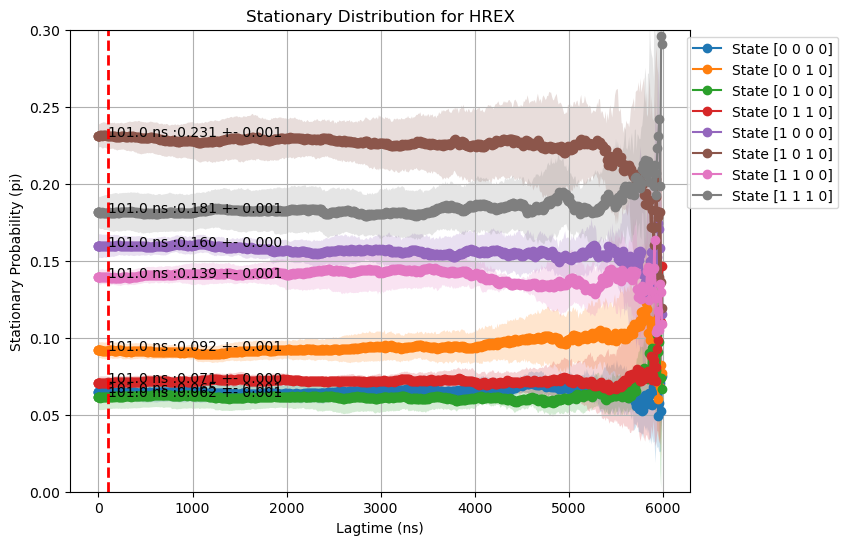

In [6]:
plt.figure(figsize=(8, 6))
state_to_plot = [0, 6, 12, 18, 24, 30, 36, 42]

# Loop through selected states and plot each separately
for i, state in enumerate(state_to_plot):
    plt.plot(lagtimes_ns, pi_all_means_0[:, i], '-o', label=f'State {index_to_state(state)}')
        
    # Add shaded region for standard deviation
    plt.fill_between(lagtimes_ns, 
                     pi_all_means_0[:, i] + pi_all_stds_0[:, i],  # Upper bound
                     pi_all_means_0[:, i] - pi_all_stds_0[:, i],  # Lower bound
                     alpha=0.2)
    
    # Annotate the first point with its value
    first_x = lagtimes_ns[14]
    first_y = pi_all_means_0[14, i]
    first_y_var = pi_all_stds[14, i]
    plt.text(first_x, first_y,  f"{first_x} ns :{first_y:.3f} +- {first_y_var:.3f}", fontsize=10)
    print(f"{first_x} ns :{first_y:.3f} +- {first_y_var:.3f}")

plt.axvline(x=first_x, color='r', linestyle='--', linewidth=2)
plt.xlabel('Lagtime (ns)')
plt.ylabel('Stationary Probability (pi)')
plt.title('Stationary Distribution for HREX')
plt.ylim(0, 0.3)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.show()


In [ ]:
## Save the data into a csv

point_to_plot = 400
lagtime_plot = 14  # index of lagtime to extract at 101 ns
selected_ns = lagtimes_ns[lagtime_plot]  # for saving

# Collect into a list of dicts for easy DataFrame creation
data_rows = []

for res_index in range(3):  # 3 trajectories
    for state_index in range(6):  # 6 states
        res = cis_trans_pi_means[state_index, res_index]  # shape (604, 2)
        std = cis_trans_pi_stds[state_index, res_index]

        mean_val = res[lagtime_plot, 1]  # Trans
        std_val = std[lagtime_plot, 1]

        data_rows.append({
            'res': res_index,
            'state': state_index,
            'lagtime_index': lagtime_plot,
            'lagtime_ns': selected_ns,
            'mean': mean_val,
            'std': std_val
        })

# Create a DataFrame
df = pd.DataFrame(data_rows)

# Save to CSV (or change to .tsv)
df.to_csv("autocoorel_data/trans_population_at_lagtime.csv", index=False)

print("Saved data to autocoorel_data/trans_population_at_lagtime.csv")


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_83125/3609894056.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 10000)


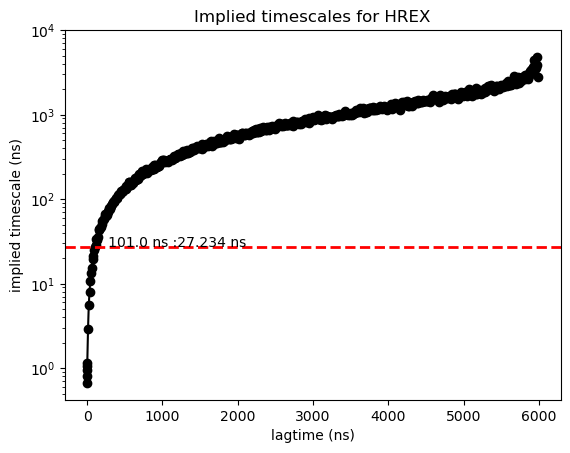

In [7]:
dt_in_ns = 0.01

plt.figure()
plt.plot(lagtimes_ns, t2_all_means*dt_in_ns, 'ko-')
plt.fill_between(lagtimes_ns, t2_all_uppers*dt_in_ns, t2_all_lowers*dt_in_ns, alpha=0.2)
plt.xlabel('lagtime (ns)')
plt.ylabel('implied timescale (ns)')

first_x = lagtimes_ns[14]
first_y = t2_all_means[14] * dt_in_ns
first_y_var = t2_all_stds[14]
plt.text(first_x, first_y, f"   {first_x} ns :{first_y:.3f} ns", fontsize=10)
plt.axhline(y=first_y, color='r', linestyle='--', linewidth=2)

plt.yscale('log')
plt.ylim(0, 10000)
plt.title(f'Implied timescales for HREX')
plt.show()


### Plot 6 state

In [10]:
import numpy as np

def index_to_state(index):
    """
    Converts an index (0..47) into a (4,) array where the first three
    entries are bits (0 or 1) and the last entry is in [0..5].
    
    The logic is inverse of:
        index = 24*a + 12*b + 6*c + x,
    where a, b, c ∈ {0,1} and x ∈ [0..5].
    """
    if not (0 <= index < 48):
        raise ValueError(f"Index out of range: {index}. Expected 0..47.")
    
    # Extract the last element in [0..5]
    x = index % 6

    # The 3-bit portion is the integer in [0..7]
    binary_index = index // 6  # in [0..7]

    # Convert that integer into a 3-bit binary string, e.g. '011'
    binary_str = format(binary_index, '03b')

    # Parse into bits [a, b, c]
    bits = np.array([int(bit) for bit in binary_str], dtype=int)

    # Combine bits and x => [a, b, c, x]
    state = np.concatenate([bits, [x]])

    return state


In [12]:
omega_loaded = Data.load("autocoorel_data/stationary_distributions.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_uppers = omega_loaded[1]
pi_all_lowers = omega_loaded[2]
pi_all_stds = omega_loaded[3]
t2_all_means = omega_loaded[4]
t2_all_uppers = omega_loaded[5]
t2_all_lowers = omega_loaded[6]
t2_all_stds = omega_loaded[7]
lagtimes_ns = omega_loaded[8]

pi_all_means.shape

(604, 48)

In [24]:
state_index = [0, 6, 12, 18, 24, 30, 36, 42]
state_index = np.array(state_index)

state_num = 6 
cis_trans_pi_means = []  # To store each (3, 604, 2)
cis_trans_pi_stds = []

for state in range(state_num):
    index = state_index + state

    # Extract columns from the second dimension
    pi_means = pi_all_means[:, index]
    pi_stds = pi_all_stds[:, index]
    print(pi_means.shape)

    # Compute row sums
    row_sums = pi_means.sum(axis=1, keepdims=True)
    # Renormalize the mean
    pi_means /= row_sums
    # Renormalize the standard deviation
    pi_stds /= row_sums

    # Print shapes to confirm correctness
    print(f"pi_means shape: {pi_means.shape}")  # Expected: (4, 8)
    print(f"pi_stds shape: {pi_stds.shape}")  # Expected: (4, 8)

    # Store each normalized pair
    cis_trans_pi_means.append(pi_means)
    cis_trans_pi_stds.append(pi_stds)

# Stack results into shape: (6, 3, 604, 2)
cis_trans_pi_means = np.stack(np.array(cis_trans_pi_means), axis=0)
cis_trans_pi_stds = np.stack(np.array(cis_trans_pi_stds), axis=0)

print("cis_trans_pi_means shape:", cis_trans_pi_means.shape)
print("cis_trans_pi_stds shape:", cis_trans_pi_stds.shape)

#cis_trans_pi_means

(604, 8)
pi_means shape: (604, 8)
pi_stds shape: (604, 8)
(604, 8)
pi_means shape: (604, 8)
pi_stds shape: (604, 8)
(604, 8)
pi_means shape: (604, 8)
pi_stds shape: (604, 8)
(604, 8)
pi_means shape: (604, 8)
pi_stds shape: (604, 8)
(604, 8)
pi_means shape: (604, 8)
pi_stds shape: (604, 8)
(604, 8)
pi_means shape: (604, 8)
pi_stds shape: (604, 8)
cis_trans_pi_means shape: (6, 604, 8)
cis_trans_pi_stds shape: (6, 604, 8)


Thermo 0, Conf 0: 101.00 ns : 0.065
Thermo 0, Conf 1: 101.00 ns : 0.092
Thermo 0, Conf 2: 101.00 ns : 0.062
Thermo 0, Conf 3: 101.00 ns : 0.071
Thermo 0, Conf 4: 101.00 ns : 0.160
Thermo 0, Conf 5: 101.00 ns : 0.231
Thermo 0, Conf 6: 101.00 ns : 0.139
Thermo 0, Conf 7: 101.00 ns : 0.181


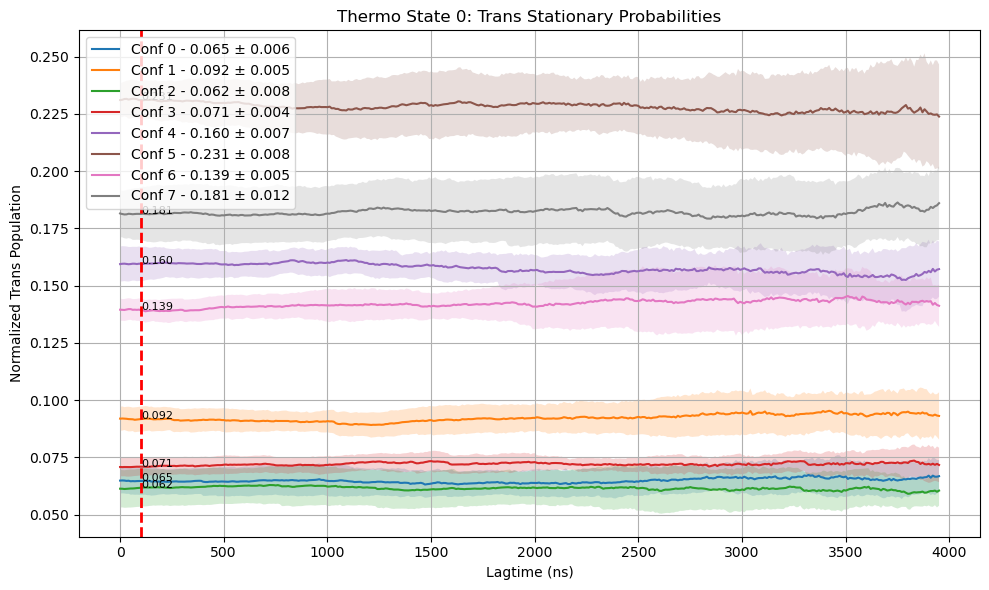

Thermo 1, Conf 0: 101.00 ns : 0.062
Thermo 1, Conf 1: 101.00 ns : 0.092
Thermo 1, Conf 2: 101.00 ns : 0.062
Thermo 1, Conf 3: 101.00 ns : 0.073
Thermo 1, Conf 4: 101.00 ns : 0.157
Thermo 1, Conf 5: 101.00 ns : 0.236
Thermo 1, Conf 6: 101.00 ns : 0.137
Thermo 1, Conf 7: 101.00 ns : 0.182


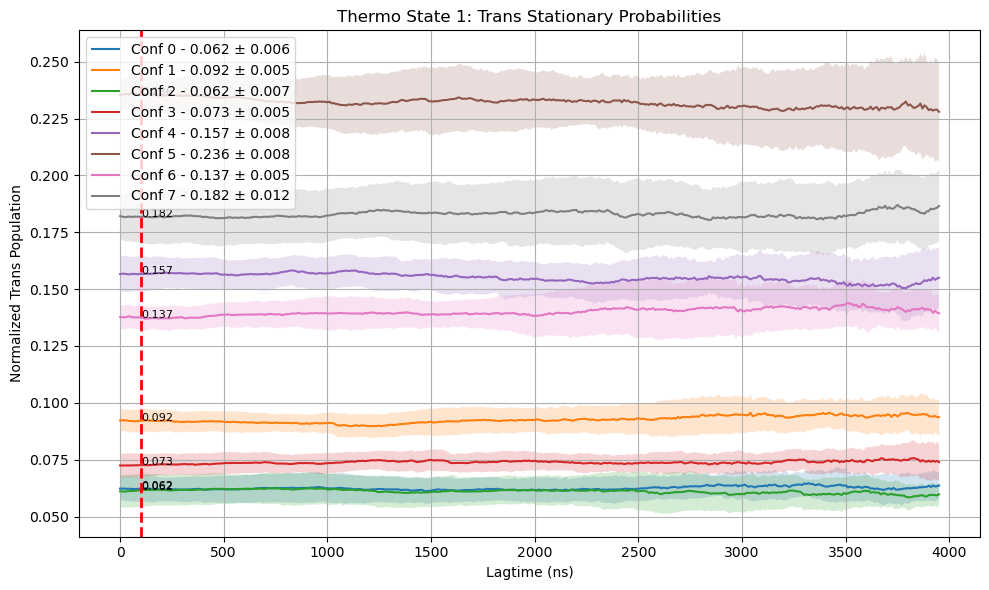

Thermo 2, Conf 0: 101.00 ns : 0.058
Thermo 2, Conf 1: 101.00 ns : 0.096
Thermo 2, Conf 2: 101.00 ns : 0.062
Thermo 2, Conf 3: 101.00 ns : 0.077
Thermo 2, Conf 4: 101.00 ns : 0.149
Thermo 2, Conf 5: 101.00 ns : 0.240
Thermo 2, Conf 6: 101.00 ns : 0.134
Thermo 2, Conf 7: 101.00 ns : 0.185


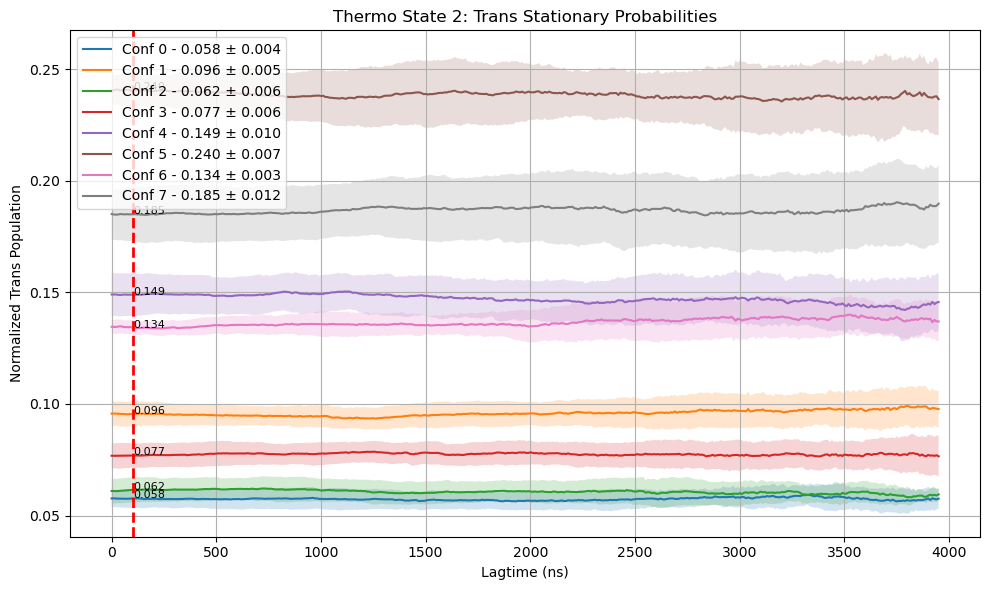

Thermo 3, Conf 0: 101.00 ns : 0.055
Thermo 3, Conf 1: 101.00 ns : 0.102
Thermo 3, Conf 2: 101.00 ns : 0.060
Thermo 3, Conf 3: 101.00 ns : 0.086
Thermo 3, Conf 4: 101.00 ns : 0.133
Thermo 3, Conf 5: 101.00 ns : 0.232
Thermo 3, Conf 6: 101.00 ns : 0.134
Thermo 3, Conf 7: 101.00 ns : 0.197


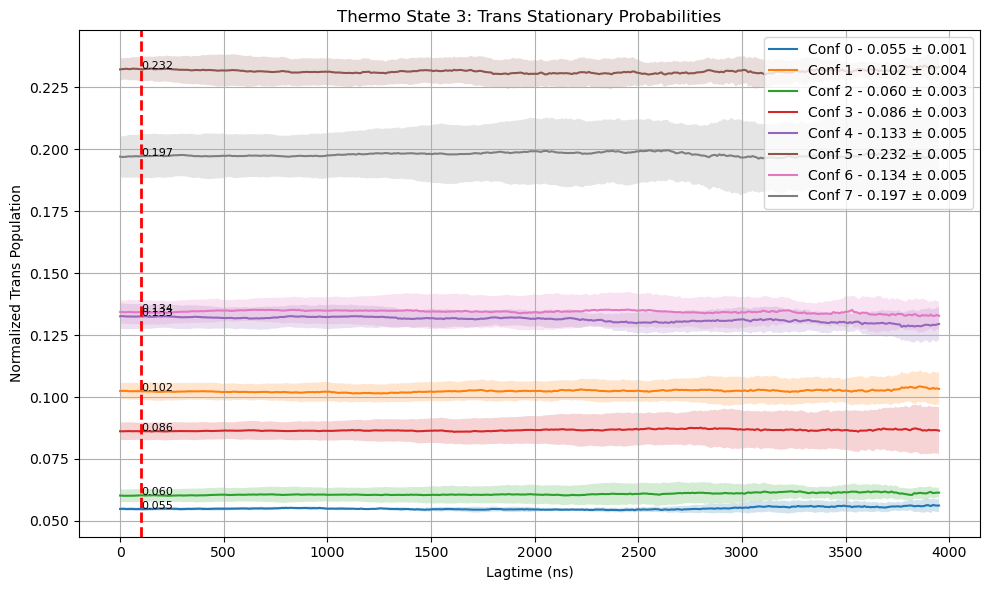

Thermo 4, Conf 0: 101.00 ns : 0.059
Thermo 4, Conf 1: 101.00 ns : 0.104
Thermo 4, Conf 2: 101.00 ns : 0.062
Thermo 4, Conf 3: 101.00 ns : 0.094
Thermo 4, Conf 4: 101.00 ns : 0.125
Thermo 4, Conf 5: 101.00 ns : 0.219
Thermo 4, Conf 6: 101.00 ns : 0.133
Thermo 4, Conf 7: 101.00 ns : 0.204


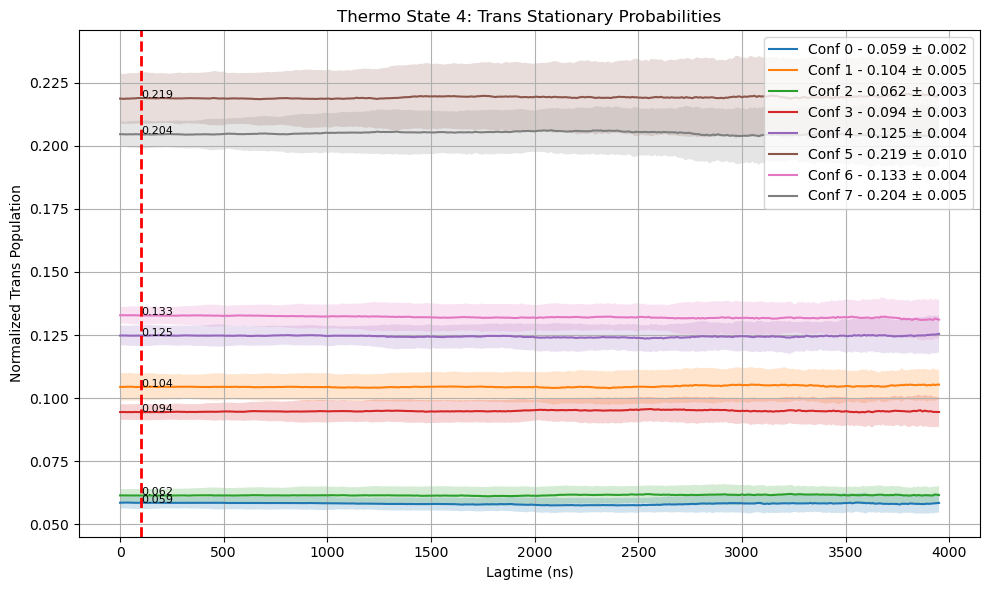

Thermo 5, Conf 0: 101.00 ns : 0.059
Thermo 5, Conf 1: 101.00 ns : 0.099
Thermo 5, Conf 2: 101.00 ns : 0.068
Thermo 5, Conf 3: 101.00 ns : 0.102
Thermo 5, Conf 4: 101.00 ns : 0.123
Thermo 5, Conf 5: 101.00 ns : 0.206
Thermo 5, Conf 6: 101.00 ns : 0.135
Thermo 5, Conf 7: 101.00 ns : 0.208


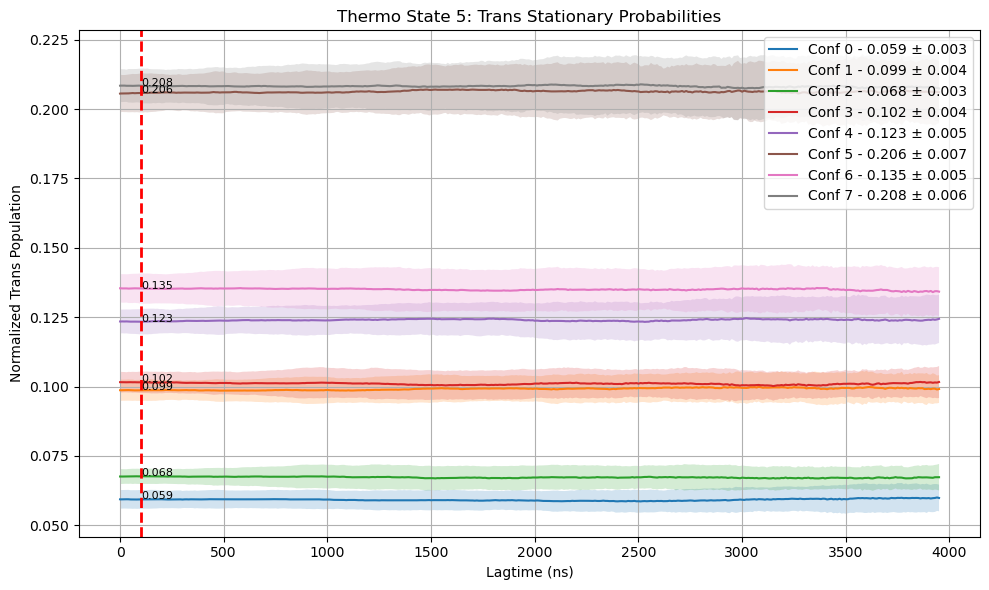

In [27]:
point_to_plot = 400
lagtime_plot = 14  # Index of lagtime to annotate

thermo_state_num = 6 
comform_state_num = 8

for thermo in range(thermo_state_num):
    plt.figure(figsize=(10, 6))

    for conform in range(comform_state_num):
        res = cis_trans_pi_means[thermo, :point_to_plot, conform]  # shape (point_to_plot,)
        std = cis_trans_pi_stds[thermo, :point_to_plot, conform]  # shape (point_to_plot,)

        plt.plot(
            lagtimes_ns[:point_to_plot],
            res,
            label=f"Conf {conform} - {res[lagtime_plot]:.3f} ± {std[lagtime_plot]:.3f}"
        )

        plt.fill_between(
            lagtimes_ns[:point_to_plot],
            res + std,
            res - std,
            alpha=0.2
        )

        # Annotate point at selected lagtime
        x_val = lagtimes_ns[lagtime_plot]
        y_val = res[lagtime_plot]
        plt.text(x_val, y_val, f"{y_val:.3f}", fontsize=8)

        print(f"Thermo {thermo}, Conf {conform}: {x_val:.2f} ns : {y_val:.3f}")

    plt.axvline(x=lagtimes_ns[lagtime_plot], color='r', linestyle='--', linewidth=2)
    plt.title(f"Thermo State {thermo}: Trans Stationary Probabilities")
    plt.xlabel("Lagtime (ns)")
    plt.ylabel("Normalized Trans Population")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [31]:
# === Setup ===
point_to_plot = 400
lagtime_plot = 14  # Index of lagtime (e.g., ~101 ns)
selected_ns = lagtimes_ns[lagtime_plot]

thermo_state_num = 6
conform_state_num = 8

output_dir = "autocoorel_data"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

data_rows = []

# === Loop through all thermo and conformational states ===
for thermo in range(thermo_state_num):
    for conform in range(conform_state_num):
        mean_curve = cis_trans_pi_means[thermo, :, conform]  # shape: (604,)
        std_curve = cis_trans_pi_stds[thermo, :, conform]    # shape: (604,)

        mean_val = mean_curve[lagtime_plot]
        std_val = std_curve[lagtime_plot]

        data_rows.append({
            'thermo_state': thermo,
            'conform_state': conform,
            'lagtime_index': lagtime_plot,
            'lagtime_ns': selected_ns,
            'mean': mean_val,
            'std': std_val
        })

# === Save to CSV ===
df = pd.DataFrame(data_rows)
output_path = os.path.join(output_dir, "trans_population_at_lagtime_8conforms.csv")
df.to_csv(output_path, index=False)

print(f"✅ Saved data to: {output_path}")
df

✅ Saved data to: autocoorel_data/trans_population_at_lagtime_8conforms.csv


,thermo_state,conform_state,lagtime_index,lagtime_ns,mean,std
0,0,0,14,101.0,0.064663,0.006085
1,0,1,14,101.0,0.091691,0.005428
2,0,2,14,101.0,0.061737,0.008275
3,0,3,14,101.0,0.070925,0.003871
4,0,4,14,101.0,0.159501,0.007332
5,0,5,14,101.0,0.230997,0.008321
6,0,6,14,101.0,0.139207,0.005082
7,0,7,14,101.0,0.181280,0.011630
8,1,0,14,101.0,0.062248,0.005739
9,1,1,14,101.0,0.092155,0.004977
